In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


### Categorical data to be converted to numeric data
colors = (["red", "green", "yellow", "red", "blue"])

### integer mapping using LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(colors)
print(integer_encoded)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

### One hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

print(onehot_encoded)

[2 1 3 2 0]
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


# Settings, Directory Specs, and Imports

In [2]:
# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 0

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered04/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime
import pyprojroot


matplotlib.rcParams.update({'font.size': 22})

# Function Definitions

In [3]:
def now_to_str():
    now = str(datetime.now())
    return now[0:4] + '_' + now[5:7] + '_' + now[8:10] + '_' + now[11:13] + now[14:16]

# eICU Data Wrangling

In [4]:
# Read files from csv
patient = pd.read_csv(dir_read + 'patient.csv')
admissiondx = pd.read_csv(dir_read + 'admissiondx.csv')
diagnosis = pd.read_csv(dir_read + 'diagnosis.csv')
ptusid_pos = pd.read_csv(dir_read + 'pos_ptunitstayid.csv')

# Create dataframe of patientunitstayids in negative class
tmp = patient[~patient['patientunitstayid'].isin(ptusid_pos['patientunitstayid'])]
ptusid_neg = tmp[['patientunitstayid']]

# Create labels
ptusid_neg = ptusid_neg.assign(label=0)
ptusid_pos = ptusid_pos.assign(label=1)

# Add labels to "patient" dataframe and move 'label' column to left
ptusid_w_label = pd.concat([ptusid_pos, ptusid_neg])
ptusid_w_label.shape[0]
ptusid_w_label = ptusid_w_label.set_index('patientunitstayid')
patient = patient.set_index('patientunitstayid')
patient = patient.join(ptusid_w_label)

# Move 'label' column to left
cols = list(patient.columns)
cols = [cols[-1]] + cols[:-1]
patient = patient[cols]

# Remove patients who weigh less than 40 kg or more than 400 kg
patient = patient[(patient['admissionweight'] > 40) & \
                   (patient['admissionweight'] < 400)]

# Remove patients who are shorter than 100 cm (3.2 ft) or taller than 230 cm (~7.5 ft)
patient = patient[(patient['admissionheight'] > 100 ) & (patient['admissionheight'] < 230)]
# Drop unneeded columns of patient
patient = patient.drop(columns=['hospitalid', 'wardid', 'dischargeweight', 'unitdischargetime24', \
                                'unitdischargeoffset', 'unitdischargelocation'])

In [5]:
# Dummy variables for gender, ethnicity, unitstaytype
patient = pd.concat([patient, pd.get_dummies(patient['gender'], prefix='gender')], axis=1)
patient = pd.concat([patient, pd.get_dummies(patient['ethnicity'], prefix='ethnicity')], axis=1)
patient = pd.concat([patient, pd.get_dummies(patient['unitstaytype'], prefix='unitstaytype')], axis=1)

In [6]:
patient

,label,patienthealthsystemstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,...,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141168,0,128919,Female,70,Caucasian,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,...,0,0,1,0,0,0,1,0,0,0
141194,0,128941,Male,68,Caucasian,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,...,0,0,1,0,0,0,1,0,0,0
141197,0,128943,Male,71,Caucasian,"Sepsis, pulmonary",162.6,20:21:00,-25,Emergency Department,...,0,0,1,0,0,0,1,0,0,0
141203,0,128948,Female,77,Caucasian,"Arrest, respiratory (without cardiac arrest)",160.0,22:23:00,-1336,Floor,...,0,0,1,0,0,0,1,0,0,0
141208,0,128952,Female,25,Caucasian,"Overdose, sedatives, hypnotics, antipsychotics...",172.7,11:23:00,-1,Emergency Department,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353216,0,2743066,Female,50,African American,"Cystectomy, other reasons",165.1,19:19:00,0,Operating Room,...,1,0,0,0,0,0,1,0,0,0
3353226,0,2743075,Female,79,African American,"Effusions, pleural",121.9,17:09:00,-66,Emergency Department,...,1,0,0,0,0,0,1,0,0,0
3353235,0,2743084,Male,50,Caucasian,"CHF, congestive heart failure",175.3,04:55:00,-34,Emergency Department,...,0,0,1,0,0,0,1,0,0,0


In [7]:
patient['admissionheight'].nsmallest(10)

patientunitstayid
3225972    100.7
1345246    101.6
1590497    101.6
1750909    101.6
1353299    101.7
963688     102.0
1591244    102.0
984114     102.9
1058197    103.0
1505594    104.0
Name: admissionheight, dtype: float64

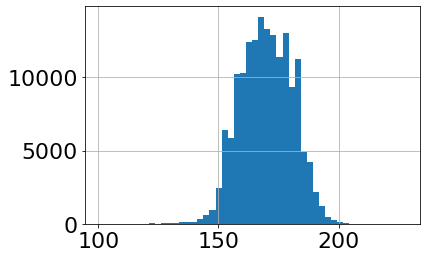

In [8]:
patient['admissionheight'].hist(bins=50)

In [9]:
patient['admissionheight'].mean()

169.6826978959314

In [10]:
nstds = 5
print(str(169+nstds*patient['admissionheight'].std()))
print(str(169-nstds*patient['admissionheight'].std()))

223.2900111739172
114.70998882608279


In [11]:
patient_pos = patient[patient['label']==1]
patient_neg = patient[patient['label']==0]
patient[patient['label']==1].shape[0]

1998

In [12]:
patient_pos.head()

,label,patienthealthsystemstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,...,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141448,1,129154,Male,65,Hispanic,Coma/change in level of consciousness (for hep...,167.6,08:33:00,0,Emergency Department,...,0,0,0,1,0,0,1,0,0,0
143466,1,130702,Female,60,Caucasian,"Sepsis, pulmonary",170.0,04:40:31,-1,Other Hospital,...,0,0,1,0,0,0,1,0,0,0
144689,1,131641,Male,57,Caucasian,Extremity only trauma,170.2,23:15:00,-1,Emergency Department,...,0,0,1,0,0,0,1,0,0,0
149317,1,135247,Female,48,African American,Heart transplant,170.2,01:31:00,-709,Operating Room,...,1,0,0,0,0,0,1,0,0,0
150626,1,136249,Female,51,Caucasian,"Sepsis, renal/UTI (including bladder)",165.1,16:27:00,-3902,Floor,...,0,0,1,0,0,0,1,0,0,0


In [13]:
pd.set_option('display.max_rows', 30)

In [14]:
apacheaddx_all = patient['apacheadmissiondx'].value_counts()

In [15]:
apacheaddx_all

Sepsis, pulmonary                                 8064
Infarction, acute myocardial (MI)                 6671
CHF, congestive heart failure                     6188
CVA, cerebrovascular accident/stroke              6152
Sepsis, renal/UTI (including bladder)             4885
                                                  ... 
Lymphoma, Hodgkins                                   2
Papillary muscle rupture                             2
Myositis, viral                                      1
Thyroid neoplasm                                     1
Pelvic relaxation (cystocele, rectocele, etc.)       1
Name: apacheadmissiondx, Length: 390, dtype: int64

In [16]:
foo = patient[patient['apacheadmissiondx'].isnull()]

# Defining X and y

In [17]:
# Define X and y
#tmp1 = patient[['age', 'admissionweight', 'admissionheight']]
X = pd.concat([patient[['age', 'admissionweight', 'admissionheight']], \
               patient.filter(like='gender_'), \
               patient.filter(like='unitstaytype_'), \
               patient.filter(like='ethnicity_')], axis=1)
X = X.assign(bmi=lambda x: x.admissionweight/((x.admissionheight/100)**2))

y = patient['label']

# Partition and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)
X_train

,age,admissionweight,admissionheight,gender_Female,gender_Male,unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,bmi
patientunitstayid,,,,,,,,,,,,,,,,
3063742,63,90.30,172.7,1,0,1,0,0,0,0,0,1,0,0,0,30.276319
863571,81,70.40,152.4,1,0,1,0,0,0,0,0,1,0,0,0,30.311172
330007,65,56.38,154.9,1,0,1,0,0,0,0,0,1,0,0,0,23.497531
1814855,91,73.90,182.9,0,1,1,0,0,0,0,0,1,0,0,0,22.091084
2507515,82,64.00,157.5,1,0,1,0,0,0,0,0,1,0,0,0,25.799950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817672,81,60.30,154.9,1,0,1,0,0,0,0,0,1,0,0,0,25.131272
3205230,39,90.70,170.0,0,1,1,0,0,0,0,0,1,0,0,0,31.384083
418911,73,56.01,180.3,0,1,1,0,0,0,0,0,1,0,0,0,17.229557


In [18]:
a = X.admissionheight.nlargest(30)

In [19]:
a.index

Int64Index([2307268, 2307269, 2512098, 2976683,  776576,  532025, 3341842,
            2693907,  372427,  967213,  967214, 1064982, 1187372, 3007928,
             983545, 2725590, 3174377,  381355, 1061049, 1585777, 2161612,
            2420073, 2876485,  263439, 1846733, 2966453, 3172287,  457176,
             477890,  496250],
           dtype='int64', name='patientunitstayid')

In [20]:
patient[patient.index.isin(list(a.index))]

,label,patienthealthsystemstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,...,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,unitstaytype_admit,unitstaytype_readmit,unitstaytype_stepdown/other,unitstaytype_transfer
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
263439,0,226427,Male,87,Caucasian,"Bleeding, lower GI",208.28,06:01:00,-36,Emergency Department,...,0,0,1,0,0,0,1,0,0,0
372427,0,319329,Male,42,African American,Seizures (primary-no structural brain disease),210.80,16:13:00,-307,Emergency Department,...,1,0,0,0,0,0,1,0,0,0
381355,0,326682,Male,56,Caucasian,"Overdose, street drugs (opiates, cocaine, amph...",208.30,01:30:00,-236,Emergency Department,...,0,0,1,0,0,0,1,0,0,0
457176,0,388488,Male,88,Caucasian,MI admitted > 24 hrs after onset of ischemia,205.70,05:24:00,-108,NaN,...,0,0,1,0,0,0,1,0,0,0
477890,0,405206,Male,57,Caucasian,"CVA, cerebrovascular accident/stroke",205.70,11:29:00,-117,Emergency Department,...,0,0,1,0,0,0,1,0,0,0
496250,0,420169,Male,60,African American,Ventriculostomy,205.70,16:46:00,-69,NaN,...,1,0,0,0,0,0,1,0,0,0
532025,0,449135,Male,63,Other/Unknown,"Infarction, acute myocardial (MI)",213.40,04:55:00,-1478,Floor,...,0,0,0,0,0,1,1,0,0,0
776576,0,596388,Male,89,Caucasian,"Sepsis, pulmonary",218.00,19:25:00,-106,Emergency Department,...,0,0,1,0,0,0,1,0,0,0
967213,0,712394,Male,60,Caucasian,"CHF, congestive heart failure",210.80,00:24:00,61,Emergency Department,...,0,0,1,0,0,0,1,0,0,0


# Breakpoint

In [21]:
if do_plots == 1:
    %matplotlib notebook
    import seaborn as sns

    sns.distplot(patient['age'], bins=15)
    plt.xlabel('Age (yrs)')
    plt.title('Distribution of Age Among All Patients')

    plt.figure()
    sns.distplot(patient['admissionweight'], bins=200)
    plt.xlabel('Admission Weight (kg)')
    plt.title('Distribution of Weight Among All Patients')

    plt.figure()
    sns.distplot(patient_pos['admissionweight'], color='red')
    sns.distplot(patient_neg['admissionweight'], color='blue')
    plt.xlabel('Admission Weight (kg)')
    plt.legend('VTE', 'No VTE')

    plt.figure()
    sns.distplot(patient_pos['age'], color='red', bins=15)
    sns.distplot(patient_neg['age'], color='blue', bins=15)
    plt.xlabel('Age (years)')

    plt.figure()
    sns.distplot(patient_pos['admissionweight'], color='red', bins=100)
    sns.distplot(patient_neg['admissionweight'], color='blue', bins=200)
    plt.xlabel('Admission Weight (kg)')

In [22]:
if streamlit_status == 1:
    age = 30
    admissionweight = 50
if streamlit_status == 2:
    age = st.slider('Age', 19, 90)
    admissionweight = st.slider('Admission Weight (kg)', 40, 300)
if (streamlit_status == 1) | (streamlit_status == 2): 
    input_data = {'age': [age], 'admissionweight': [admissionweight]}
    X_test = pd.DataFrame(input_data, columns=['age', 'admissionweight'])

# Model and Predict

0.6429988837901526
F1 score is: 0.029664587898196527
159261 patients in negative class
1998 patients in positive class
If you predict 0 all the time, accuracy is 0.98761%
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.565


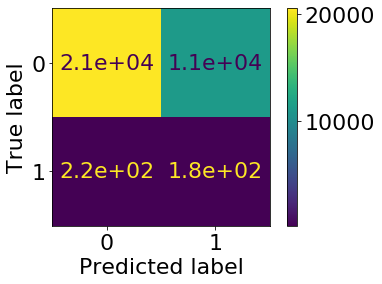

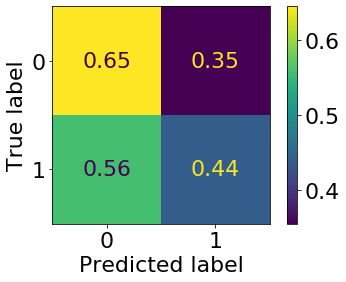

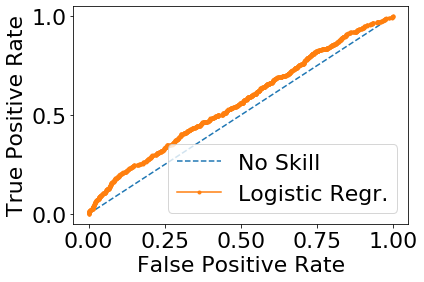

NameError: name 'prob_sc' is not defined

In [25]:
# Logistic Regression - basic form

logisticRegr_sc = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
logisticRegr_sc.fit(X_train, y_train)
file_name_pickle = 'model_' + now_to_str() + '.pickle'
pickle.dump(logisticRegr_sc, open(file_name_pickle, 'wb'))

# if (streamlit_status == 1) | (streamlit_status == 2):
#     logisticRegr_sc = pickle.load(open(file_name_pickle_read, 'rb'))

yhat_logisticRegr_sc = logisticRegr_sc.predict(X_test)
prob_logisticRegr_sc = logisticRegr_sc.predict_proba(X_test)[:,1]
#lprob_sc = logisticRegr_sc.predict_log_proba(X_test)[:,1]

scores_sc = logisticRegr_sc.score(X_test, y_test)
print(scores_sc)
print('F1 score is: ' + str(f1_score(y_test, yhat_logisticRegr_sc)))

# Print baseline accuracy
N0_bl = patient[patient['label']==0].shape[0]
N1_bl = patient[patient['label']==1].shape[0]
print('{:d} patients in negative class'.format(N0_bl))
print('{:d} patients in positive class'.format(N1_bl))
print('If you predict 0 all the time, accuracy is {:.5f}%'.format(N0_bl/(N0_bl+N1_bl)))

cm = confusion_matrix(list(y_test), yhat_logisticRegr_sc)
plot_confusion_matrix(logisticRegr_sc, X_test, list(y_test))
plot_confusion_matrix(logisticRegr_sc, X_test, list(y_test),  normalize='true')

# ROC curve (https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
noskill_probs = [0 for _ in range(len(y_test))]
noskill_auc = roc_auc_score(y_test, noskill_probs)
logisticRegr_auc = roc_auc_score(y_test, prob_logisticRegr_sc)
print('No Skill: ROC AUC=%.3f' % (noskill_auc))
print('Logistic: ROC AUC=%.3f' % (logisticRegr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, prob_logisticRegr_sc)

plt.figure()
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regr.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

print('prob_sc:  min = ' + str(np.min(prob_sc)))
print('\t    max = ' + str(np.max(prob_sc)))

In [ ]:
# Random Forest Classification - basic form
from sklearn.ensemble import RandomForestClassifier
rfc_vanilla = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rfc_vanilla.fit(X_train, y_train)

# Breakpoint